# Assignment 4
Training a simple neural net for relation classification.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 8.4MB/s 
     |████████████████████████████████| 901kB 51.1MB/s 
     |████████████████████████████████| 3.3MB 49.7MB/s 


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoConfig, AutoModel, BertModel

In [ ]:
# Check if there's a GPU available for train loop
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)


In this work we will use the hugingface framework for transformers training and inference. We recomand reading the documentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** Write a funtion *read_data* for reading the data from a single file (either train or test). This function recieves a filepath and returns a list of sentence. Every sentence is encoded as a touple, where the first element is the sentence string and the second the label (also represented as a sting). 

In [ ]:
def read_data(filepath):
    data = []
    #TODO... write your code accordingly 
    f = open(filepath, "r")
    lines = f.readlines()
    for i in range(0, len(lines)-1,4):
      line = lines[i].split(" ", 1)[1].strip().strip('"')
      label = lines[i+1].strip().split('(')[0]
      data.append((line,label))
    return data

!git clone https://github.com/kfirbar/nlp-course
train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
test = read_data('/content/nlp-course/TEST_FILE_FULL.TXT')

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), done.


Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [ ]:
def create_label_mapper(data):
  label2id = {}
  counter = 0 
  for i in range(len(data)):
    label = data[i][1]
    if label not in label2id:
      label2id[label] = counter
      counter += 1 
  return label2id

ids = create_label_mapper(train)

In [ ]:
print(f'Number of unique labels: {len(ids)}')

Number of unique labels: 10


**Task 2:** Write a function *prepare_data* that takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. The function also aggregate the samples into batches. BERT Uses pretrained tokanization and embedding. you can access the tokanization and indexing using the BertTokenizer class.

In [ ]:
def map_label(row):
    return ids[row]

def prepare_data(data, tokenizer, batch_size=16): 
    data_sequences = [] #list of 3 tensors, each element is of batch size

    data = train
    df = pd.DataFrame(data, columns = ['Sentence', 'Label'])
    
    # Sort the date according to sentence size
    df.sort_values(by="Sentence", key=lambda x: x.str.len(), inplace = True)
    df.reset_index(inplace = True)
    df['mapped_label'] = df['Label'].apply(map_label)

    for i in range(0, len(data)-batch_size+1, batch_size):
      labelsofbatch = list(df['mapped_label'][i:i+batch_size])
      sentences = list(df['Sentence'][i:i+batch_size])
        
      encoded_dict = tokenizer(
                        sentences,                      
                        add_special_tokens = True, 
                        return_attention_mask = True,
                        return_token_type_ids = False,
                        return_tensors = 'pt',  
                        padding = True               
                   )
      
      # Sentence encoding, masks, and label of batch
      input_per_batch = encoded_dict['input_ids']
      mask_per_batch = encoded_dict['attention_mask']
      labels = torch.tensor(labelsofbatch) 
      data_sequences.append((input_per_batch, mask_per_batch, labels))
    return data_sequences

num_labels = len(ids)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',num_labels=num_labels)
train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

**Task 3:** In this part we classify the sentences using the BertForSequenceClassification model. To save resources, we initialize the optimizer with the final layer of the model. You are also allowed to change the learning rate.

In [ ]:
# def get_parameters(params):
#   # TODO - your code...
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)

# Optimizer (ADAM is a fancy version of SGD)
# optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=0.0001)

# We decided to use all layers for high performence of the model
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, eps = 1e-8)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Task 4:** Write a training loop, which takes a BertForSequenceClassification model and number of epochs to train on. The loss is always CrossEntropyLoss and the optimizer is always Adam. You are allowed to split the train to train and dev sets.

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) #/ len(labels_flat)

In [ ]:
model.cuda()
torch.cuda.synchronize()

def train_loop(model, n_epochs, train_data, dev_data):
  # Loss function
  criterion = nn.CrossEntropyLoss() 
  total_steps = len(train_data) * n_epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, 
                                              num_training_steps = total_steps)
  for e in range(0, n_epochs):
    # TODO - your code goes here...
    model.train()
    training_stats = []
    total_train_loss = 0

    for batch in train_data: # For each batch of training data
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        model.zero_grad()
        outputs = model(input_ids,
                        token_type_ids=None,
                        attention_mask=input_mask
                        )
        
        loss = criterion(outputs.logits, labels) 
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step() 
        scheduler.step()         

    avg_train_loss = total_train_loss / len(train_data)
    print(f'Average training loss on epoch {e+1}: {avg_train_loss}')

    # Evaluation on validation set
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dev_data: # For each batch of training data
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            output = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask
                                   )
            
        # Accumulate the validation loss.
        loss = criterion(outputs.logits, labels) 
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = output.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(train_data)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(train_data)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

In [ ]:
n_epochs = 2
train_size = int(0.95 * len(train_sequences))
val_size = len(train_sequences) - train_size

# Divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(train_sequences, [train_size, val_size])

train_loop(model, n_epochs, train_dataset, val_dataset)

Average training loss on epoch 1: 1.1648599873718462
  Accuracy: 0.71
  Validation Loss: 0.19
Average training loss on epoch 2: 0.43785278848911585
  Accuracy: 0.72
  Validation Loss: 0.22


**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [ ]:
def evaluate(model, test_data, caption):
  # TODO - your code goes here
  model.eval()
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  lables_test = []
  lables_pred = []

  for batch in test_data:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      with torch.no_grad():        
        outputs = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask
                       )
        
      # Move logits and labels to CPU
      logits = outputs.logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # True labels
      lables_test  += list(label_ids)

      # Predicted label
      pred_flat = np.argmax(logits, axis=1).flatten()
      lables_pred += list(pred_flat)

  print(caption)
  print(classification_report(lables_test, lables_pred, zero_division = 1))

In [ ]:
evaluate(model, test_sequences, 'BERT model')

BERT model
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       941
           1       0.92      0.73      0.81      1410
           2       0.93      0.96      0.94       504
           3       0.94      0.97      0.95       690
           4       0.95      0.97      0.96      1003
           5       0.95      0.98      0.97       845
           6       0.92      0.97      0.94       540
           7       0.92      0.99      0.96       634
           8       0.87      0.95      0.91       717
           9       0.91      0.95      0.93       716

    accuracy                           0.92      8000
   macro avg       0.92      0.94      0.93      8000
weighted avg       0.92      0.92      0.92      8000



**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS toekn for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

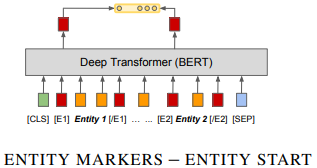

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [ ]:
def entities_indices(sent):
  len_marker = len("<e1>")
  s1 = sent.find("<e1>") + len_marker
  s2 = sent.find("<e2>") + len_marker
  return (s1, s2)

def prepare_data_MTB(data, tokenizer, batch_size=8):
    data_sequences = []
    # TODO - your code...
    df = pd.DataFrame(data, columns = ['Sentence', 'Label'])
    df.sort_values(by="Sentence", key=lambda x: x.str.len(), inplace = True)
    df.reset_index(inplace = True)
    df['mapped_label'] = df['Label'].apply(map_label)
    df['start_entities'] = df['Sentence'].apply(entities_indices)

    for i in range(0, len(data)-batch_size+1, batch_size):
          sentences = list(df['Sentence'][i:i+batch_size])
          batch_labels = list(df['mapped_label'][i:i+batch_size])
          start_entities = list(df['start_entities'][i:i+batch_size])

          encoded_dict = tokenizer(
                            sentences,                      
                            add_special_tokens = True, 
                            return_attention_mask = True,
                            return_token_type_ids = False,
                            return_tensors = 'pt',  
                            padding = True               
                      )
          
          # Sentence encoding, label of batch and start entities
          s = encoded_dict['input_ids']
          l = torch.tensor(batch_labels) 
          i = torch.tensor(start_entities) 

          data_sequences.append((s, l, i))

    return data_sequences

train_sequences = prepare_data_MTB(train, tokenizer)
test_sequences = prepare_data_MTB(test, tokenizer)

Create a new model that uses the "entity markers - Entity start" method.

We did not have enough time to get the new model train loop to compile and return an output. The idea that we wanted to implement was have a similar model to the previous task but have this model take additional parameters, the concatination of the embedding of [e1] and [e2] and the indicies of the entity markers. These additional parameters should in theory return more accurate results as the model is receiving more exact information on the location of these entities to classify. 

In the previous task, the model may not know the difference between the ordering of e1 and e2. Here since we provide their indicies the model can better predict the relationship between them given their ordering and context in sentence. 

In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model_name):
      self.config = AutoConfig.from_pretrained(base_model_name)
      super().__init__()
      self.model = AutoModel.from_config(self.config)
      self.position_ids = None
      # TODO - your code...

      self.num_labels = self.config.num_labels
      self.bert = BertModel(self.config, add_pooling_layer=False)
      self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
      self.classifier = nn.Linear(self.config.hidden_size, self.config.num_labels)
      # self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        next_sentence_label=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
      # TODO - your code...
       
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output, pooled_output = outputs[:2]
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)

        total_loss = None
        if labels is not None and next_sentence_label is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
            total_loss = masked_lm_loss + next_sentence_loss

        if not return_dict:
            output = (prediction_scores, seq_relationship_score) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output

        return BertForPreTrainingOutput(
            loss=total_loss,
            prediction_logits=prediction_scores,
            seq_relationship_logits=seq_relationship_score,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

model = MTB('bert-base-uncased').to(device)

#BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

In [ ]:
def train_MTB(model, n_epochs, train_data, dev_data):
  # Loss function
  criterion = nn.CrossEntropyLoss() 
  total_steps = len(train_data) * n_epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, 
                                              num_training_steps = total_steps)
  for e in range(0, n_epochs):
    # TODO - your code goes here...
    model.train()
    training_stats = []
    total_train_loss = 0

    for batch in train_data: # For each batch of training data
        input_ids = batch[0].to(device)
        index = batch[2].to(device)
        labels = batch[1].to(device)

        print(index.shape)
        
        model.zero_grad()
        outputs = model(input_ids,position_ids=index
                        
                        )
        
        loss = criterion(outputs.logits, labels) 
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # to help prevent the "exploding gradients" problem
        optimizer.step() # update params
        scheduler.step() # update learning rate        

    avg_train_loss = total_train_loss / len(train_data)
    print(f'Average training loss on epoch {e+1}: {avg_train_loss}')

    #Evaluation on validation set
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dev_data: # For each batch of training data
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            output = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask
                          
                                   )
            
        # Accumulate the validation loss.
        loss = criterion(outputs.logits, labels) 
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = output.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(train_data)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(train_data)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
train_size = int(0.95 * len(train_sequences))
val_size = len(train_sequences) - train_size

n_epochs = 1
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(train_sequences, [train_size, val_size])

train_MTB(model, n_epochs, train_dataset, val_dataset)


# train_loop(model, n_epochs, train_sequences, dev_data)
evaluate(model, test_sequences)

torch.Size([8, 2])


RuntimeError: ignored

**Good luck!**